In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from glob import glob
from sklearn import preprocessing
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Resizing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Importing Data

In [2]:
colab_path = "path-to-data"

In [3]:
raw_data = pd.read_csv(colab_path+"flipkart_com-ecommerce_sample_1050.csv")
print(raw_data.shape)

(1050, 15)


In [4]:
def extract_category(df):
    df["category"] = df["product_category_tree"].apply(
        lambda category_tree: category_tree.split(" >>")[0].replace('["', "")
    )

    return df


data = extract_category(raw_data)

le = preprocessing.LabelEncoder()
le.fit(data["category"])
data["encoded_category"] = le.transform(data["category"])

In [5]:
path = colab_path+"Images/"

image_data = data[["category", "encoded_category", "image"]]
categories = image_data["category"].unique()
image_data

,category,encoded_category,image
0,Home Furnishing,4,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,0,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,0,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,4,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,4,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...,...
1045,Baby Care,0,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,Baby Care,0,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,Baby Care,0,5912e037d12774bb73a2048f35a00009.jpg
1048,Baby Care,0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


# Supervised Classification


## First approach without data augmentation

This approach consists in pre-processing the images manually.


We start by initializing a VGG16 pre-trained model, to which we will add layers that are specific to our data set.

In [6]:
def build_model():
    model0 = VGG16(include_top=False, weights="imagenet",
                   input_shape=(224, 224, 3))
    for layer in model0.layers:
        layer.trainable = False

    x = model0.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation="softmax")(x)

    model = Model(inputs=model0.input, outputs=predictions)
    model.compile(
        loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
    )

    print(model.summary())

    return model

In [7]:
data, test_data, y_train, y_test = train_test_split(
    image_data[["encoded_category", "image"]], image_data["category"], test_size=0.2
)

Preprocessing the images manually to fit the model's requirements

In [8]:
def image_preprocessing(data):
    prepared_images = []
    for image in data["image"]:
        img = load_img(path + image, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
    return np.array(prepared_images)

Separating our images into two sets, one used for training and validation and the other one for testing purposes

In [9]:
images = image_preprocessing(data)
print(images.shape)
test_images = image_preprocessing(test_data)
print(test_images.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [10]:
X = images
y = to_categorical(data["encoded_category"])

X_test = test_images
y_test = to_categorical(test_data["encoded_category"])

y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Separating the training data subset into train and validation data sets

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)
X_train.shape

(630, 224, 224, 3)

Defining the model's monitoring parameters.

We will be monitoring validation loss and stop training if there is no decrease of the validation loss after 5 epochs.

The validation loss is used to assess the model's performance on the validation data and is calculated from a sum of the errors for each example in the validation set.

In [12]:
with tf.device("/gpu:0"):
    first_model = build_model()

model_saving_file = "./first_model_best_weights.h5"
checkpoint = ModelCheckpoint(
    model_saving_file, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

We use the training data to train the model and the validation data to evaluate the model's performance based on the validation loss and validation accuracy

In [13]:
with tf.device("/gpu:0"):
    first_model_history = first_model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1,
    )

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.2108 - accuracy: 0.4730
Epoch 1: val_loss improved from inf to 1.54406, saving model to ./first_model_best_weights.h5
10/10 [==============================] - 26s 1s/step - loss: 5.2108 - accuracy: 0.4730 - val_loss: 1.5441 - val_accuracy: 0.7238
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 1.9119 - accuracy: 0.6794
Epoch 2: val_loss improved from 1.54406 to 1.27475, saving model to ./first_model_best_weights.h5
10/10 [==============================] - 4s 396ms/step - loss: 1.9119 - accuracy: 0.6794 - val_loss: 1.2747 - val_accuracy: 0.7571
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.2742 - accuracy: 0.7524
Epoch 3: val_loss improved from 1.27475 to 1.14593, saving model to ./first_model_best_weights.h5
10/10 [==============================] - 3s 340ms/step - loss: 1.2742 - accuracy: 0.7524 - val_loss: 1.1459 - val_accuracy: 0.7905
Epoch 4/50
10/10 [==============================] - ETA: 0s - loss: 0.7958 - accuracy: 0.8143
Epoch 4: val_loss did not improve from 1.14593
10/10 [==============================] - 4s 370ms/step - loss: 0.7958 - accuracy: 0.8143 - val_loss: 1.2916 - val_accuracy: 0.7619
Epoch 5/50
10/10 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.8127

The model stopped improving after 7 runs

Score of the last epoch run :

In [14]:
loss, accuracy = first_model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))
print()
loss, accuracy = first_model.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy: {:.4f}".format(accuracy))
print("Validation Loss: {:.4f}".format(loss))

20/20 [==============================] - 8s 252ms/step - loss: 0.0138 - accuracy: 0.9968
Training Accuracy: 0.9968
Training Loss: 0.0138

7/7 [==============================] - 1s 118ms/step - loss: 1.2438 - accuracy: 0.8143
Validation Accuracy: 0.8143
Validation Loss: 1.2438


Score of the optimal epoch run :


In [15]:
first_model.load_weights(model_saving_file)

loss, accuracy = first_model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))
print("Validation Loss: {:.4f}".format(loss))

loss, accuracy = first_model.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test Loss: {:.4f}".format(loss))

Validation Accuracy: 0.8143
Validation Loss: 1.0131
Test Accuracy: 0.7857
Test Loss: 1.0821


Plotting accuracy and loss values

In [16]:
def plot_history(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)

  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  plt.title("VGG16 Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  accuracy = "Accuracy last value: " + str(
      round(history.history["accuracy"][-1], 2)
  )
  val_accuracy = "Validation accuracy last value: " + str(
      round(history.history["val_accuracy"][-1], 2)
  )
  plt.legend([accuracy, val_accuracy])

  plt.subplot(1, 2, 2)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title("VGG16 Model Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  loss = "Loss last value: " + \
      str(round(history.history["loss"][-1], 2))
  val_loss = "Validation loss last value: " + str(
      round(history.history["val_loss"][-1], 2)
  )
  plt.legend([loss, val_loss])

  plt.tight_layout()
  plt.show()

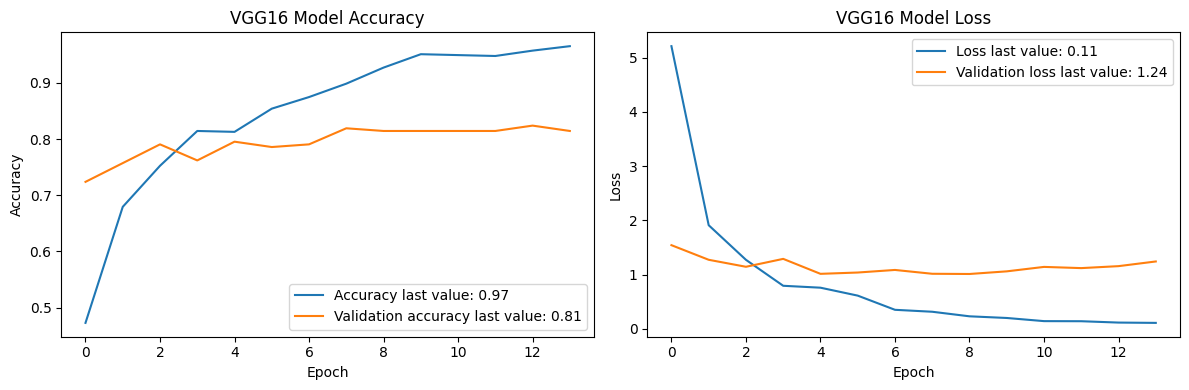

In [17]:
plot_history(first_model_history)

The model performed well, with an 84% accuracy on the test set. We can however see signs of overfitting as the validation score remains pretty stable while the training accuracy score keeps rising.

Creating confusion matrix

In [18]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(first_model.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 1s 118ms/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 5 3 1 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 2 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 2 4 5 5 3 0 0 3 3 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 3 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 2 3 6 3 6 5]

[0 2 6 2 1 1 3 3 2 0 2 6 1 6 5 2 1 1 4 2 0 2 6 2 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 5 3 1 2 6 5 2 0 1 6 4 6 5 3 3 3 3 3 5 4 0 4 4 0 6 6 2 5 4 0 1 3 5 3 2 6
 4 6 2 4 5 1 3 0 5 4 1 5 2 2 3 1 3 5 4 3 2 4 6 0 2 0 3 4 5 2 1 3 3 2 2 2 3
 5 3 2 5 3 1 6 2 4 2 5 3 0 3 3 3 6 3 6 5 5 2 6 6 3 1 2 3 4 3 0 1 1 0 4 0 0
 5 4 3 6 4 0 4 3 2 4 1 2 4 0 3 2 4 1 5 2 4 1 0 2 1 6 0 2 4 4 0 0 6 3 0 4 6
 5 0 2 3 1 6 0 2 1 5 0 5 0 2 3 1 6 1 3 2 3 6 3 2 5]


In [19]:
conf_mat = confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[21  0  0  4  3  1  0]
 [ 0 22  2  2  0  1  1]
 [ 0  0 29  2  0  0  0]
 [ 1  1  1 28  1  0  0]
 [ 4  1  1  1 23  0  0]
 [ 1  1  4  2  0 23  0]
 [ 0  0  3  1  0  0 25]]


In [20]:
print(classification_report(y_val_num, y_val_pred))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75        29
           1       0.88      0.79      0.83        28
           2       0.72      0.94      0.82        31
           3       0.70      0.88      0.78        32
           4       0.85      0.77      0.81        30
           5       0.92      0.74      0.82        31
           6       0.96      0.86      0.91        29

    accuracy                           0.81       210
   macro avg       0.83      0.81      0.82       210
weighted avg       0.83      0.81      0.82       210



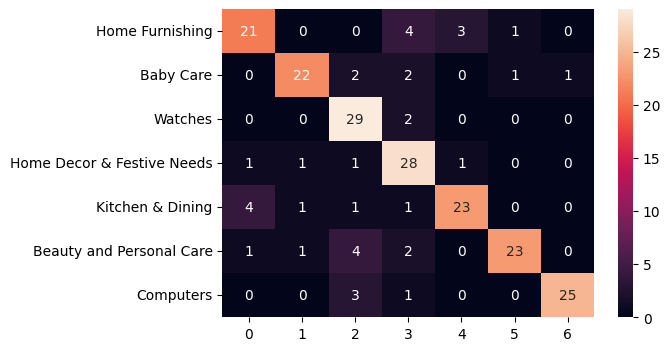

In [21]:
df_cm = pd.DataFrame(
    conf_mat, index=[label for label in categories], columns=[i for i in "0123456"]
)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True)
plt.show()

The confusion matrix illustrates the model's accuracy.

It also shows that home furnishing and kitchen & dining items were the categories most often mistaken for one another.

## Second approach without data augmentation

Using Keras preprocessing utilities to prepare the images before training the model.

In [22]:
def split_data(size, subset_type, path):
    return tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=size, subset=subset_type
                    )

The images were split into one training/validation set and one testing set and each image was moved to a dedicated category subfolder in order to generate a training, a validation and a test set using keras' preprocessing util method image_dataset_from_directory.

In [23]:
train_set = split_data(0.2, "training", colab_path+"ImagesTrainSet/")
validation_set = split_data(0.2, "validation", colab_path+"ImagesTrainSet/")
test_set = split_data(0, None, colab_path+"ImagesTestSet/")

Found 875 files belonging to 7 classes.
Using 700 files for training.
Found 875 files belonging to 7 classes.
Using 175 files for validation.
Found 175 files belonging to 7 classes.


We then use the same model as for the previous method, with a VGG16 model with added layers specific to our dataset

In [24]:
with tf.device("/gpu:0"):
    second_model = build_model()

second_model_saving_file = "./second_model_best_weights.h5"
checkpoint = ModelCheckpoint(
    second_model_saving_file,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [25]:
with tf.device('/gpu:0'):
    second_model_history = second_model.fit(train_set,
                    validation_data=validation_set,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 5.8648 - accuracy: 0.5014
Epoch 1: val_loss improved from inf to 2.40521, saving model to ./second_model_best_weights.h5
22/22 [==============================] - 89s 3s/step - loss: 5.8648 - accuracy: 0.5014 - val_loss: 2.4052 - val_accuracy: 0.6457
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - ETA: 0s - loss: 2.1339 - accuracy: 0.6943
Epoch 2: val_loss improved from 2.40521 to 1.74946, saving model to ./second_model_best_weights.h5
22/22 [==============================] - 12s 486ms/step - loss: 2.1339 - accuracy: 0.6943 - val_loss: 1.7495 - val_accuracy: 0.6743
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.3160 - accuracy: 0.7714
Epoch 3: val_loss improved from 1.74946 to 1.63045, saving model to ./second_model_best_weights.h5
22/22 [==============================] - 9s 344ms/step - loss: 1.3160 - accuracy: 0.7714 - val_loss: 1.6304 - val_accuracy: 0.7200
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.8558 - accuracy: 0.8071
Epoch 4: val_loss improved from 1.63045 to 1.61595, saving model to ./second_model_best_weights.h5
22/22 [==============================] - 12s 382ms/step - loss: 0.8558 - accuracy: 0.8071 - val_loss: 1.6159 - val_accuracy: 0.7543
Epoch 5/50
22/22 [===================

Last epoch's score

In [26]:
def get_last_score(model, train_set, validation_set):
  loss, accuracy = model.evaluate(train_set, verbose=True)
  print("Training Accuracy   : {:.4f}".format(accuracy))
  print()
  loss, accuracy = model.evaluate(validation_set, verbose=True)
  print("Validation Accuracy :  {:.4f}".format(accuracy))

In [27]:
get_last_score(second_model, train_set, validation_set)

22/22 [==============================] - 7s 222ms/step - loss: 0.0063 - accuracy: 0.9986
Training Accuracy   : 0.9986

6/6 [==============================] - 3s 121ms/step - loss: 1.4778 - accuracy: 0.7886
Validation Accuracy :  0.7886


Optimal score

In [28]:
def get_optimal_score(model, file, validation_set, test_set):
  model.load_weights(file)

  loss, accuracy = model.evaluate(validation_set, verbose=False)
  print("Validation Accuracy :  {:.4f}".format(accuracy))

  loss, accuracy = model.evaluate(test_set, verbose=False)
  print("Test Accuracy       :  {:.4f}".format(accuracy))


In [29]:
get_optimal_score(second_model, second_model_saving_file, validation_set, test_set)

Validation Accuracy :  0.7600
Test Accuracy       :  0.7829


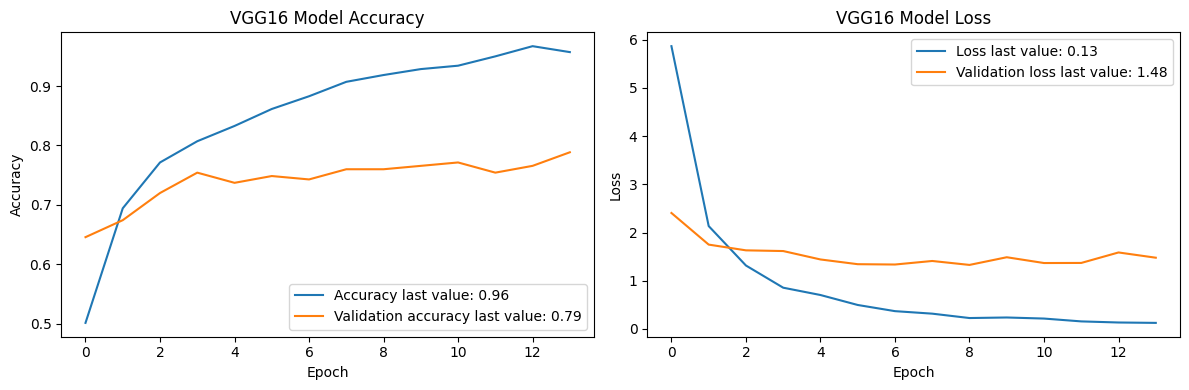

In [30]:
plot_history(second_model_history)

The results are slighty lower with this technique compared to the previous one which used manual preprocessing, with an 80% accuracy on the test set.

The graph also shows signs of overfitting

## Data Augmentation

Applying random transformations to the training set in order to increase its diversity without having to add more data.

Visualizing transformations on a sample image:

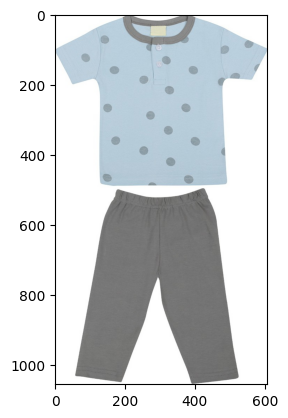

In [31]:
sample_image = imread(path + image_data["image"][42])
plt.imshow(sample_image)
sample_image_with_batch = tf.expand_dims(sample_image, axis=0)

In [32]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential(
    [Resizing(IMG_SIZE, IMG_SIZE), Rescaling(1.0 / 255)]
)

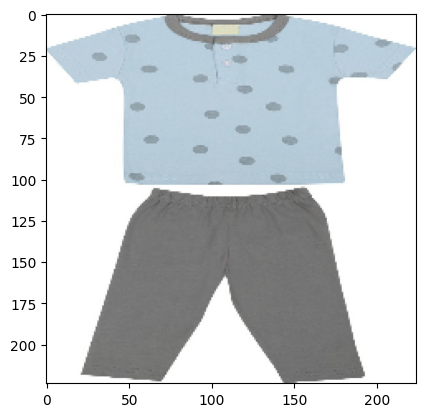

In [33]:
result = resize_and_rescale(sample_image_with_batch)
result_augmented = tf.squeeze(result, axis=0)

_ = plt.imshow(result_augmented)

In [34]:
data_augmentation = Sequential(
        [RandomFlip("horizontal_and_vertical",  input_shape=(224, 224, 3)), RandomRotation(0.2)]
    )

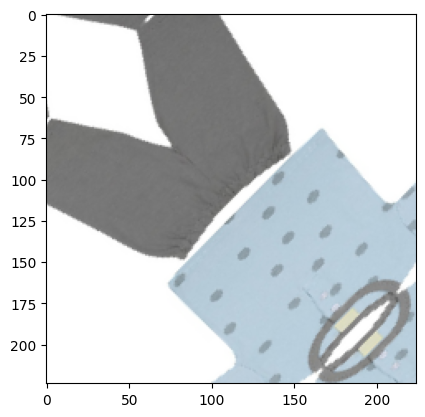

In [35]:
result = data_augmentation(result)
result_augmented = tf.squeeze(result, axis=0)
_ = plt.imshow(result_augmented)

### Implementation

In [36]:
class_names = train_set.class_names
print(class_names)

['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


Creating the new model with added data augmentation layers

In [37]:
def build_data_augmentation_model():
    rescale = Sequential([Rescaling(1.0 / 255)])
    data_augmentation = Sequential(
        [RandomFlip("horizontal_and_vertical",  input_shape=(224, 224, 3)), RandomRotation(0.2)]
    )

    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential(
        [
            data_augmentation,
            rescale,
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation="relu"),
            Dropout(0.5),
            Dense(7, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
    )

    print(model.summary())

    return model

Defining the monitoring steps

In [38]:
with tf.device("/gpu:0"):
    data_augmentation_model = build_data_augmentation_model()

data_augmentation_saving_file = "./data_augmentation_best_weights.h5"
checkpoint = ModelCheckpoint(
    data_augmentation_saving_file,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [39]:
with tf.device('/gpu:0'):
    da_history = data_augmentation_model.fit(train_set,
                    validation_data=validation_set,
                    batch_size=32, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 1.8080 - accuracy: 0.2929
Epoch 1: val_loss improved from inf to 1.49041, saving model to ./data_augmentation_best_weights.h5
22/22 [==============================] - 11s 352ms/step - loss: 1.8080 - accuracy: 0.2929 - val_loss: 1.4904 - val_accuracy: 0.6114
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 1.4844 - accuracy: 0.4886
Epoch 2: val_loss improved from 1.49041 to 1.36932, saving model to ./data_augmentation_best_weights.h5
22/22 [==============================] - 12s 377ms/step - loss: 1.4844 - accuracy: 0.4886 - val_loss: 1.3693 - val_accuracy: 0.4971
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 1.3117 - accuracy: 0.5257
Epoch 3: val_loss improved from 1.36932 to 1.20291, saving model to ./data_augmentation_best_weights.h5
22/22 [==============================] - 13s 491ms/step - loss: 1.3117 - accuracy: 0.5257 - val_loss: 1.2029 - val_accuracy: 0.6000
Epoch 4/50
22/

In [40]:
get_last_score(data_augmentation_model, train_set, validation_set)

22/22 [==============================] - 9s 280ms/step - loss: 0.4760 - accuracy: 0.8514
Training Accuracy   : 0.8514

6/6 [==============================] - 2s 114ms/step - loss: 0.8628 - accuracy: 0.7486
Validation Accuracy :  0.7486


In [41]:
get_optimal_score(data_augmentation_model,data_augmentation_saving_file, validation_set, test_set)

Validation Accuracy :  0.7600
Test Accuracy       :  0.8114


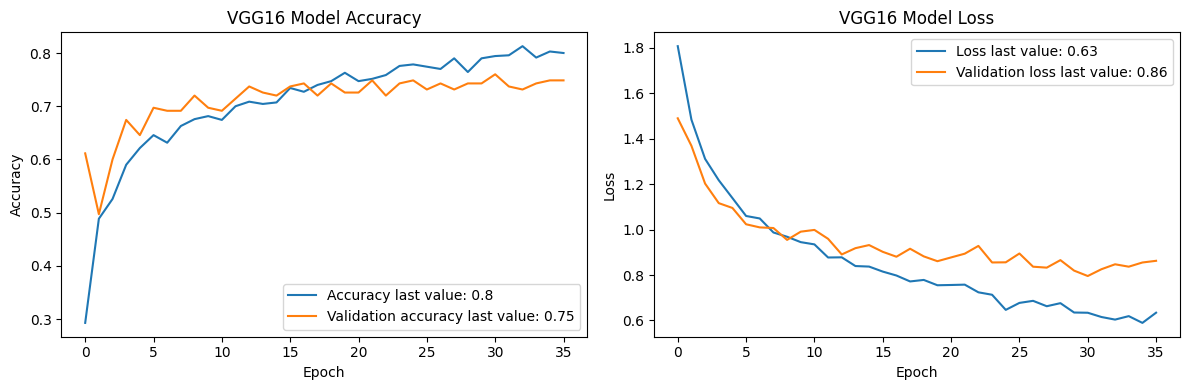

In [42]:
plot_history(da_history)